In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the hyperparameter-optimised values.

In [3]:
# Author's Original Model: 3 layers, 120 filters per layer, filter length 8, 40 nodes in the dense layer
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                     dropout2=0,dropout3=0.2)

### Train Copy of Model for Variation Tests

In [87]:
# Scaled-Down Test, see below!
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                      inp_len=50, nodes=40, layers=1, nbr_filters=1, filter_len=8, dropout1=0,
#                      dropout2=0,dropout3=0)

In [6]:
# e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test['rl'], e_test['pred'])
# print 'r-squared = ', r

r-squared =  0.7270459621613151


In [7]:
# name = 'one_filter_one_layer.hdf5'
# model.save('./saved_models/'+name)

## Analyze Model Predictive Power as Function of Network Size

Just how much information is in this model? In other words, how quickly do we lose predictive power as we shrink the size of the network?

Test network from 120 filters per layer to 1, from 3 layers to 1 layer.

In [10]:
# I recorded these by hand because I wanted to restart the kernel every time I re-made a model
# in order to make sure the initializations were all done with the same random seed

n_filters = [1,3,10,20,60,120]
rsquared = [0.7402,0.8216,0.9106,0.9205,0.9307,0.9339]

nf_nodrop = [1,3,10]
rsq_nodrop = [0.7424,0.8309,0.9095]

nf_onelayer = [1,3,10] #note no dropout
rsq_onelayer = [0.7270,0.8317,0.8632]

small_model_efficiency_data = pd.DataFrame({ "N_Filters": n_filters, "R-squared": rsquared })                               
#small_model_efficiency_data.to_csv('./saved_data/small_model_data.csv')
small_model_efficiency_data2 = pd.DataFrame({ "N_filters": [1,3,10], "R-squared_NoDropout": rsq_nodrop,
                                            "R-squared_NoDropout_OneLayer": rsq_onelayer })
#small_model_efficiency_data.to_csv('./saved_data/small_model_data2.csv')

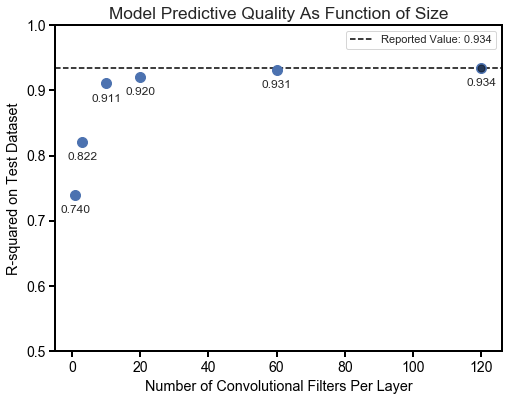

In [95]:
fig,ax = plt.subplots(figsize=(8,6))
ax.axhline(0.93385044762,xmax=123,xmin=0,linestyle='--',label='Reported Value: 0.934',color='black')
ax.plot(n_filters,rsquared,marker='o',markersize=10,linestyle='None')
ax.plot([120],[0.933850],marker='o',markersize=7,alpha=0.5,color='black')
ax.set_xlabel("Number of Convolutional Filters Per Layer",size='large')
ax.set_ylabel("R-squared on Test Dataset",size='large')
ax.set_title("Model Predictive Quality As Function of Size",size='x-large')
ax.set_ylim(top=1.0,bottom=0.5)
plt.legend()

for x,y in zip(n_filters,rsquared):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-18), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


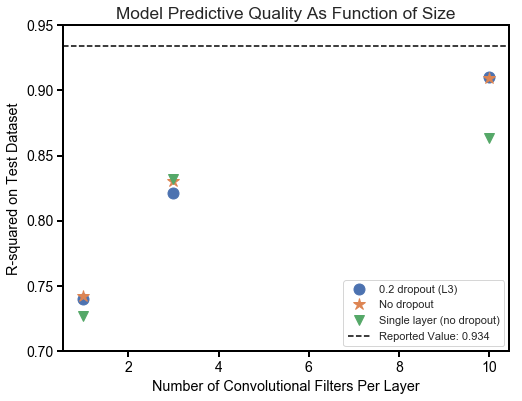

In [82]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(n_filters[:3],rsquared[:3],marker='o',markersize=11,linestyle='None',label='0.2 dropout (L3)')
ax.plot(nf_nodrop,rsq_nodrop,marker='*',markersize=12,linestyle='None',label='No dropout')
ax.plot(nf_onelayer,rsq_onelayer,marker='v',markersize=10,linestyle='None',label='Single layer (no dropout)')
ax.set_xlabel("Number of Convolutional Filters Per Layer",size='large')
ax.set_ylabel("R-squared on Test Dataset",size='large')
ax.axhline(0.93385044762,xmax=123,xmin=0,linestyle='--',label='Reported Value: 0.934',color='black')
ax.set_title("Model Predictive Quality As Function of Size",size='x-large')
ax.set_ylim(top=0.95,bottom=0.7)
plt.legend()

### And now, we return to our scheduled programming...

Evaluate model. Return predicted mean ribosome load as a dataframe column labeled 'pred'.

In [62]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.7791101441250295


Save model

In [6]:
#model.save('./saved_models/my_special_model.hdf5')

### Plotting test results

In [7]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

W0809 10:07:06.133291 4567111104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 10:07:06.182420 4567111104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 10:07:06.212472 4567111104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 10:07:06.358632 4567111104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0809 10:07:06.366897 4567111104 deprecati

## What Does the Model Structure Look Like?

In [96]:
x = model.get_weights()
print len(x)
for i in range(len(x)):
    print i, x[i].shape

6
0 (8, 4, 1)
1 (1,)
2 (50, 40)
3 (40,)
4 (40, 1)
5 (1,)


### Can we extract the actual motifs from the filters?

Text(0.5,1,'First Filter Visualized')

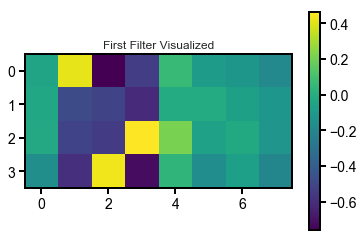

In [97]:
NFILTERS = 1
filters = [x[0][:,:,i] for i in range(NFILTERS)] #layer 1 filters
df_example = pd.DataFrame(data=filters[0])
df_example = df_example.transpose(copy=True)
plt.imshow(df_example,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
plt.colorbar()
plt.title("First Filter Visualized")
#are the ones with the highest activation the ones with AUG?
# figure out how to decode filters into BP motifs

In [68]:
x[1] # the relu activation parameter for each of the 120 filters
print x[1][:10], '...'

[-0.22936958] ...


Text(0.5,1,'Sorted ReLu parameters for the 1 Filters')

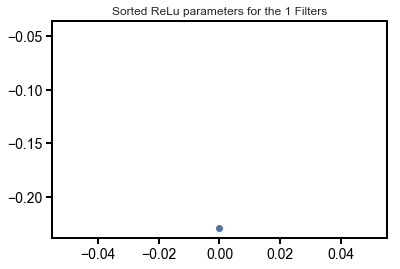

In [69]:
plt.plot(range(NFILTERS),sorted(x[1]),marker='o',linestyle='None')
plt.plot(range(NFILTERS),[-0.045]*NFILTERS)
plt.title("Sorted ReLu parameters for the "+str(NFILTERS)+" Filters")

Text(0.5,1,'Sorted ReLu parameters for the 10 Filters')

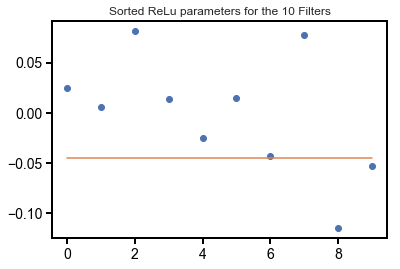

In [48]:
plt.plot(range(NFILTERS),x[1],marker='o',linestyle='None')
plt.plot(range(NFILTERS),[-0.045]*NFILTERS)
plt.title("Sorted ReLu parameters for the "+str(NFILTERS)+" Filters")
# Note that the 10th, 9th, and 6th filters are the "most important" by this metric

In [50]:
# Get just the filters with the highest relu weighting 
#   (actually...hmm, is lower better? point where switches to linear is lower, aka we care sooner...?)
top_filters = []
for i in range(NFILTERS):
    if x[1][i] < 0.1:
        top_filters.append({'index':i,'filter':filters[i]})
        print i

0
1
2
3
4
5
6
7
8
9


IndexError: index 4 is out of bounds for axis 0 with size 4

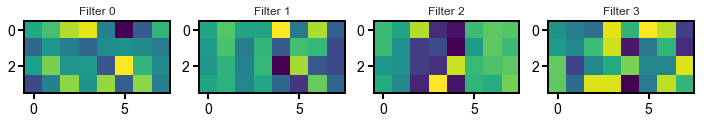

In [70]:
#fig,axes = plt.subplots(ncols=3,nrows=4,figsize=(12,10))
fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(12,4))
for j,d in enumerate(top_filters):
    #ax = axes[j/3,j%3] 
    ax = axes[j]
    data = np.transpose(d['filter'])
    p = ax.imshow(data,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
    ax.set_title("Filter "+str(d['index']))
fig.colorbar(p, ax=axes)

### What are all the 8-mers present in each dataset and the total dataset?

In [99]:
train_seqs = e_train['utr'].values
test_seqs = e_test['utr'].values
all_seqs = np.concatenate((train_seqs,test_seqs),axis=0)
print 'train', len(train_seqs), 'test', len(test_seqs), 'total', len(all_seqs)

train 260000 test 20000 total 280000


In [100]:
def get_8mer_counts(seqs_set,filename):
    dict_8mers = {}
    for i,s in enumerate(seqs_set):
        for j in range(len(s)-8):
            ss = s[j:j+8]
            dict_8mers[ss] = dict_8mers.get(ss, 0) + 1
    print 'number of unique 8mers:', len(set(dict_8mers.keys()))
    freq_8mers = pd.DataFrame(sorted(list(dict_8mers.items()),key=lambda n: n[1],reverse=True),columns=['8mer','frequency'])
    freq_8mers.to_csv("./saved_sequences/"+filename)
    return freq_8mers

#### Note that 4 to the 8th is 65536, so this is the theoretical maximum of possible different 8-mers of ATGC

In [101]:
train_8mers = get_8mer_counts(train_seqs,'train_8mers.csv')
test_8mers = get_8mer_counts(test_seqs,'test_8mers.csv')
total_8mers = get_8mer_counts(all_seqs,'total_8mers.csv')

number of unique 8mers: 65536
number of unique 8mers: 65475
number of unique 8mers: 65536


### Compute the Activation Value for every Filter and every 8-mer

In [102]:
filter_pairs = [{
    'relu_param': x[1][i],
    'filter': filters[i],
    'filter_index': i
} for i in range(len(filters))]
# each layer 1 filter paired with its relu param, for easier access

In [103]:
# get one-hot encoding
char_8mers_total = total_8mers['8mer'].values
vector_8mers_total = one_hot_encode(pd.DataFrame({'utr':char_8mers_total}),seq_len=8)

In [104]:
# This is what we want to do for each filter and 8-mer combination
print 'EXAMPLE'
print filters[0], "filter"
print vector_8mers_total[1005], "8-mer sequence"
print np.multiply(filters[0],vector_8mers_total[1005]), "element-wise multiplication"
print np.sum(np.multiply(filters[0],vector_8mers_total[1005])), "summation of product matrix"

EXAMPLE
[[-0.04423412 -0.03056789 -0.02337213 -0.15731397]
 [ 0.4138514  -0.4790037  -0.5098691  -0.5856314 ]
 [-0.75684637 -0.5093965  -0.54213524  0.4333661 ]
 [-0.5351932  -0.6097944   0.46071097 -0.7170188 ]
 [ 0.06648428 -0.00870623  0.21625842  0.03989761]
 [-0.08476555 -0.00637645 -0.0589039  -0.16002968]
 [-0.11296977 -0.06346687 -0.01797101 -0.07175086]
 [-0.1859519  -0.11491597 -0.12361874 -0.198881  ]] filter
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]] 8-mer sequence
[[-0.         -0.         -0.02337213 -0.        ]
 [ 0.41385141 -0.         -0.         -0.        ]
 [-0.75684637 -0.         -0.          0.        ]
 [-0.5351932  -0.          0.         -0.        ]
 [ 0.         -0.          0.21625842  0.        ]
 [-0.08476555 -0.         -0.         -0.        ]
 [-0.11296977 -0.         -0.         -0.        ]
 [-0.         -0.11491597 -0.         -0.        ]] element-wise multiplication
-0.

In [105]:
relu = lambda a,r: max(0,(a-r))
kernel = lambda f,s: np.sum(np.multiply(f,s))

def compute_filter_activations(filter_pairs,df_8mers,save=False,path=''):
    filter_results = []
    char_8mers = df_8mers['8mer'].values
    vector_8mers = one_hot_encode(pd.DataFrame({'utr':char_8mers}),seq_len=8)
    for i,d in enumerate(filter_pairs):
        f, r = d['filter'], d['relu_param']
        outputs = [ relu(kernel(f,s),r) for s in vector_8mers ]
        nonzero_8mer_indices = [ j for j in range(len(outputs)) if outputs[j] > 0 ]
        df = pd.DataFrame({'8mer_index': nonzero_8mer_indices, 
                           'activation': [outputs[j] for j in nonzero_8mer_indices],
                           'seq': [char_8mers[j] for j in nonzero_8mer_indices],
                           'aug_count': [char_8mers[j].count('ATG') for j in nonzero_8mer_indices],
                          })
        filter_results.append(df.sort_values(by='activation',ascending=False).head(min(len(df),2000)))
        if i % 20 == 0:
            print 'filter',i

    print 'Done'
    if save == True:
        for i,fdf in enumerate(filter_results):
            fdf.to_csv('./saved_activations/'+path+'10filter'+format(i,'02')+'.csv')

    return filter_results

In [106]:
total_results = compute_filter_activations(filter_pairs,total_8mers,save=False,path='total/')
train_results = compute_filter_activations(filter_pairs,train_8mers,save=False,path='train/')
test_results = compute_filter_activations(filter_pairs,test_8mers,save=False,path='test/')

filter 0
Done
filter 0
Done
filter 0
Done


### Visualize Sequence Motifs as Logos and PFM Heatmaps

In [107]:
## Create Motif Logo Graphics
def makeLogos(results,path,name='filter'):
    for i,res in enumerate(results):
        m = motifs.create([ Seq(s) for s in res['seq'].values ])
        title = name+format(i,'02')
        m.weblogo('./saved_logos/'+path+title+'.pdf',format='pdf',
                  color_scheme='color_classic',show_fineprint=False,show_ends=False,logo_title=title)
    print 'Done'

In [109]:
makeLogos(total_results,'total/',name='1layer1filter')
makeLogos(train_results,'train/',name='1layer11filter')
makeLogos(test_results,'test/',name='1layer1filter')

Done
Done
Done


In [43]:
def pfm(filter_df):
    seqs = filter_df['seq'].values
    A = []
    T = []
    G = []
    C = []
    for i in range(8):
        bp = ''.join([ s[i] for s in seqs])
        A.append(bp.count('A'))
        T.append(bp.count('T'))
        G.append(bp.count('G'))
        C.append(bp.count('C'))
    return pd.DataFrame({'A':A,'T':T,'G':G,'C':C})
    
    
# Question: do we want to scale the counts by the actual activation values they represent? Is that even viable?

In [44]:
total_filter_pfms = [ pfm(f) for f in total_results ]

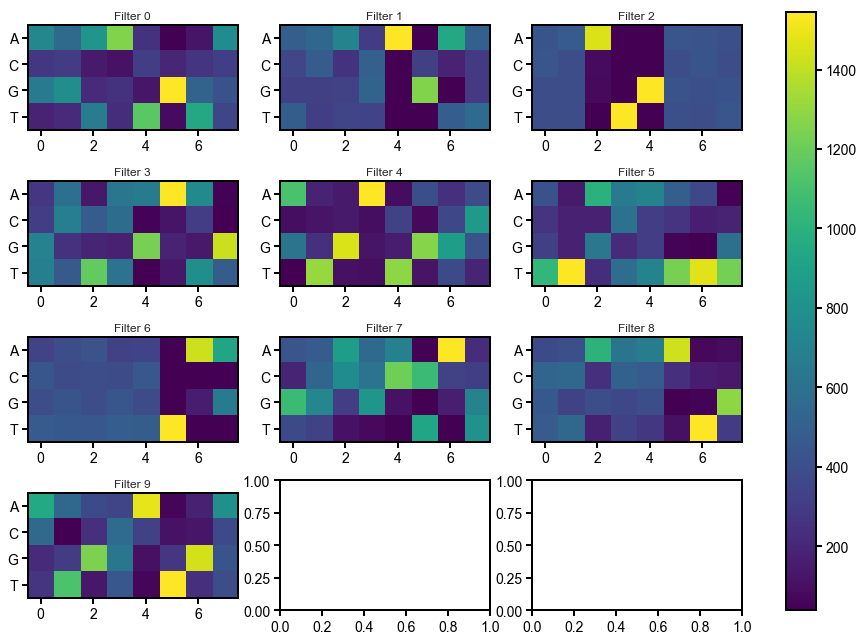

In [52]:
## Raw BP Frequency Heatmaps for the 12 Most Sensitive Filters
fig,axes = plt.subplots(ncols=3,nrows=4,figsize=(16,11))
for j,d in enumerate(top_filters):
    ax = axes[j/3,j%3] 
    data = np.transpose(total_filter_pfms[d['index']].values)
    p = ax.imshow(data,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
    ax.set_title("Filter "+str(d['index']))
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels(['A','C','G','T'],visible=True)
fig.colorbar(p, ax=axes)

### Count AUG Frequency in Top 2000 8-mers per sequence

Text(0.5,1,'Histogram of Total AUG Count in Top 2000 8mers Per Filter, Test+Train')

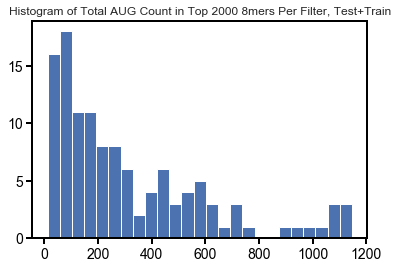

In [113]:
aug_counts = pd.DataFrame(
    data={ "total_aug":[ np.sum(f['aug_count']) for f in total_results],
           "filter_index":np.arange(len(total_results)) })
plt.hist(aug_counts['total_aug'],bins=25)
plt.title("Histogram of Total AUG Count in Top 2000 8mers Per Filter, Test+Train")

In [33]:
top_filter_indices = [ t['index'] for t in top_filters]

Text(0.5,1,'Same Histogram for Just Top Filters')

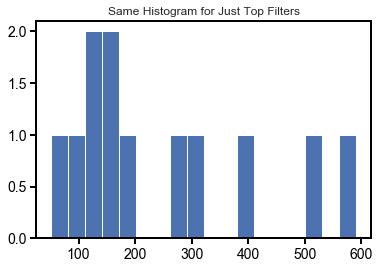

In [34]:
plt.hist(aug_counts[aug_counts['filter_index'].isin(top_filter_indices)]['total_aug'],bins=18)
plt.title("Same Histogram for Just Top Filters")

### More Histograms, Stop/Start Codon Dependence

is the average activation higher for the 8mers within the top 2000 that have a stop or a start?


Number of top 2000 8mers (non-unique) with AUG: 37355
Number of top 2000 8mers (non-unique) without AUG: 202256


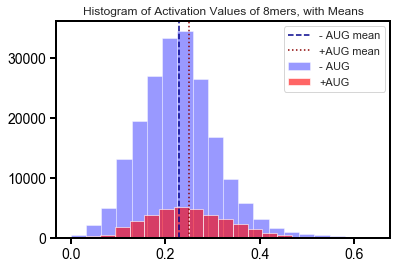

In [138]:
# Make histogram of activations for sequences with AUG and without
fig,ax = plt.subplots()
with_start = []
without_start = []
for f in total_results:
    with_start = np.concatenate((with_start,f[f['aug_count'] > 0]['activation']))
    without_start = np.concatenate((without_start,f[f['aug_count'] == 0]['activation']),axis=0)
ax.hist(without_start,color='blue',alpha=0.4,bins=20,label='- AUG')
ax.hist(with_start,color='red',alpha=0.6,bins=20,label='+AUG')
ax.axvline(np.mean(without_start),linestyle='--',color='darkblue',label='- AUG mean')
ax.axvline(np.mean(with_start),linestyle=':',color='darkred',label='+AUG mean')
ax.set_title("Histogram of Activation Values of 8mers, with Means")
ax.legend()
print 'Number of top 2000 8mers (non-unique) with AUG:', len(with_start)
print 'Number of top 2000 8mers (non-unique) without AUG:', len(without_start)

Number of top 2000 8mers (non-unique) with UAA/UAG: 49653
Number of top 2000 8mers (non-unique) without UAA/UAG: 189958


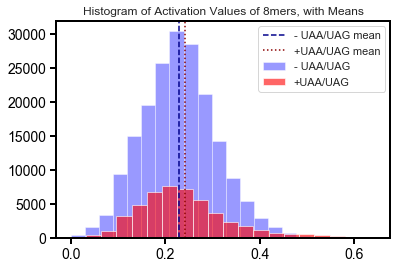

In [145]:
# Make histogram of activations for sequences with TAA/TAG and without
hasStop = lambda s: s.count('TAA') + s.count('TAG') > 0
fig,ax = plt.subplots()
with_stop = []
without_stop = []
for f in total_results:
    w = f[f['seq'].apply(hasStop) == True]
    wo = f[f['seq'].apply(hasStop) == False]
    with_stop = np.concatenate((with_stop,w['activation'])) if len(w) > 0 else with_stop
    without_stop = np.concatenate((without_stop,wo['activation'])) if len(wo) > 0 else without_stop
ax.hist(without_stop,color='blue',alpha=0.4,bins=20,label='- UAA/UAG')
ax.hist(with_stop,color='red',alpha=0.6,bins=20,label='+UAA/UAG')
ax.axvline(np.mean(without_stop),linestyle='--',color='darkblue',label='- UAA/UAG mean')
ax.axvline(np.mean(with_stop),linestyle=':',color='darkred',label='+UAA/UAG mean')
ax.set_title("Histogram of Activation Values of 8mers, with Means")
ax.legend()
print 'Number of top 2000 8mers (non-unique) with UAA/UAG:', len(with_stop)
print 'Number of top 2000 8mers (non-unique) without UAA/UAG:', len(without_stop)

In [153]:
for i,f in enumerate(total_results):
    w = f[f['seq'].apply(hasStop) == True]['activation']
    wo = f[f['seq'].apply(hasStop) == False]['activation']
    fig,ax = plt.subplots()
    ax.hist(wo,color='blue',alpha=0.4,bins=20,label='- UAA/UAG')
    ax.hist(w,color='red',alpha=0.6,bins=20,label='+UAA/UAG')
    ax.axvline(np.mean(wo),linestyle='--',color='darkblue',label='- UAA/UAG mean')
    ax.axvline(np.mean(w),linestyle=':',color='darkred',label='+UAA/UAG mean')
    ax.set_title("Activation by Stop Codon Presence, Filter "+str(i))
    ax.legend()
    plt.savefig('./plots/stop_histograms/filter'+format(i,'03')+'.png',bbox_inches='tight')
    plt.close()

In [154]:
hasStart = lambda s: s.count('ATG') > 0
for i,f in enumerate(total_results):
    w = f[f['seq'].apply(hasStart) == True]['activation']
    wo = f[f['seq'].apply(hasStart) == False]['activation']
    fig,ax = plt.subplots()
    ax.hist(wo,color='blue',alpha=0.4,bins=20,label='- AUG')
    ax.hist(w,color='red',alpha=0.6,bins=20,label='+AUG')
    ax.axvline(np.mean(wo),linestyle='--',color='darkblue',label='- AUG mean')
    ax.axvline(np.mean(w),linestyle=':',color='darkred',label='+AUG mean')
    ax.set_title("Activation by Start Codon Presence, Filter "+str(i))
    ax.legend()
    plt.savefig('./plots/start_histograms/filter'+format(i,'03')+'.png',bbox_inches='tight')
    plt.close()

## Analyze Enrichment of Start and Stop Codons

In [163]:
count_in_top2000 = { s:0 for s in total_8mers['8mer'].values }
for f in total_results:
    for s in f['seq'].values:
        count_in_top2000[s] += 1
# shows the number of times each 8mer appeared in a filter's top 2000 (all data)

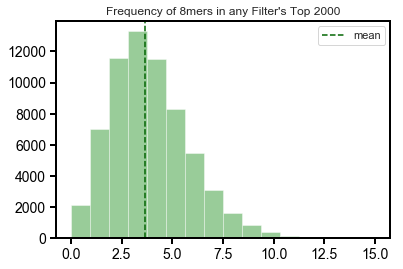

In [182]:
# histogram of how often 8mers appear in a filter's top 2000 (all data)
fig,ax = plt.subplots()
c = count_in_top2000.values()
ax.hist([c],color='green',alpha=0.4,bins=16)
ax.axvline(np.mean(c),linestyle='--',color='darkgreen',label='mean')
ax.set_title("Frequency of 8mers in any Filter's Top 2000")
ax.legend()

In [190]:
hasStart = lambda s: s.count('ATG') > 0
hasStop = lambda s: s.count('TAA') + s.count('TAG') > 0

def compute_marginals(results,fn):
    count_in_top2000 = { s:0 for s in total_8mers['8mer'].values } #out of all possible 8mers
    for f in results:
        for s in f['seq'].values:
            count_in_top2000[s] += 1
    set_in_top = set([s for s,c in count_in_top2000.items() if c > 0])
    set_not_top = set([s for s,c in count_in_top2000.items() if c == 0])
    TT = len([ s for s in list(set_in_top) if fn(s)])
    TF = len(set_in_top) - TT
    FT = len([ s for s in list(set_not_top) if fn(s)])
    FF = len(set_not_top) - FT
    print "Top 2000, True:", TT
    print "Top 2000, False:", TF
    print "Not Top, True:", FT
    print "Not Top, False:", FF
    oddsratio, pvalue = stats.fisher_exact([[TT, TF], [FT, FF]])
    print "Odds Ratio:", oddsratio
    print "P Value:", pvalue
    return (oddsratio, pvalue, [[TT, TF], [FT, FF]])
    

In [191]:
# Start Codon Enrichments
print 'TOTAL'
total_fischers_start = compute_marginals(total_results,hasStart)
print "-----"
print "TRAIN"
train_fischers_start = compute_marginals(train_results,hasStart)
print "-----"
print "TEST"
test_fischers_start = compute_marginals(test_results,hasStart)


TOTAL
Top 2000, True: 6031
Top 2000, False: 57374
Not Top, True: 17
Not Top, False: 2114
Odds Ratio: 13.07164548811821
P Value: 4.038046590217892e-66
-----
TRAIN
Top 2000, True: 6031
Top 2000, False: 57374
Not Top, True: 17
Not Top, False: 2114
Odds Ratio: 13.07164548811821
P Value: 4.038046590217892e-66
-----
TEST
Top 2000, True: 6029
Top 2000, False: 57328
Not Top, True: 19
Not Top, False: 2160
Odds Ratio: 11.955800049943447
P Value: 5.206082501812125e-66


In [192]:
print 'TOTAL'
total_fischers_stop = compute_marginals(total_results,hasStop)
print "-----"
print "TRAIN"
train_fischers_stop = compute_marginals(train_results,hasStop)
print "-----"
print "TEST"
test_fischers_stop = compute_marginals(test_results,hasStop)

TOTAL
Top 2000, True: 11758
Top 2000, False: 51647
Not Top, True: 146
Not Top, False: 1985
Odds Ratio: 3.0952519885386334
P Value: 6.134570973693473e-53
-----
TRAIN
Top 2000, True: 11758
Top 2000, False: 51647
Not Top, True: 146
Not Top, False: 1985
Odds Ratio: 3.0952519885386334
P Value: 6.134570973693473e-53
-----
TEST
Top 2000, True: 11753
Top 2000, False: 51604
Not Top, True: 151
Not Top, False: 2028
Odds Ratio: 3.058837268634137
P Value: 3.4481814251730115e-53


In [69]:
for i,s in enumerate(list(set_all_8mers)):
    if 'ATG' in s and s not in set_top_8mers:
        print i,s

9311 TCAATGAC
10746 TTATATGT
10760 TTATATGC
21290 CTCATGTA
23196 GTTCATGC
25684 TCCATGAC
27187 TTAATGGC
28242 CCCATGAA
46002 TTCATGTA
46244 CCAATGAC
48774 CCAATGTC
57732 TCAATGCA
59753 CTAATGGC
62066 CGAATGAC
62717 TCAATGTC
63010 CCAATGCA
63280 GAATGCGC


In [70]:
## Repeat for stop codons
count_taa_top = 0
count_taa_all = 0
count_taa_not_top = 0
for i,s in enumerate(list(set_all_8mers)):
    c = 1 if 'TAA' in s or 'TAG' in s or 'TGA' in s else 0
    count_taa_all += c
    if s in set_top_8mers:
        count_taa_top += c
    else:
        count_taa_not_top += c

# Table of Marginal Values
YY = count_taa_top
NY = count_taa_not_top
YN = len(set_top_8mers) - count_taa_top
NN = len(set_all_8mers) - len(set_top_8mers) - count_taa_not_top
print 'in top, has TAA/TAG/TGA:', YY
print 'not in top, has TAA/TAG/TGA:', NY
print 'in top, no TAA/TAG/TGA:', YN
print 'not in top, no TAA/TAG/TGA:', NN

in top, has TAA/TAG: 17348
not in top, has TAA/TAG: 214
in top, no TAA/TAG: 46009
not in top, no TAA/TAG: 1904


In [71]:
oddsratio, pvalue = stats.fisher_exact([[YY, NY], [YN, NN]])
print oddsratio
print pvalue

3.354747130945327
1.8283745641123367e-83


# Visualize Model Results

In [78]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [7]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


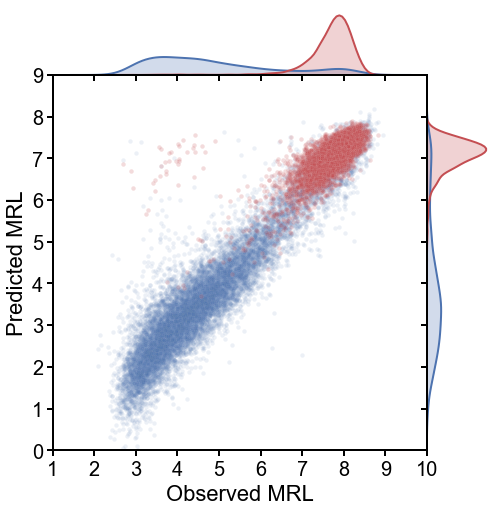

In [8]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

## EVERYTHING BELOW THIS HEADER IS ADDED

### So, just what are these off-diagonal UTRS in the graph above?

In [15]:
### BELOW IS MY OWN SANDBOX

# so rl (that is RL, not R one!) is the observed MRL column, and pred is the predicted column

off_diagonals = e_test[(e_test['rl']<4.6)&(e_test['pred']>5.4)]
len(off_diagonals)

48

In [16]:
off_diagonals

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r6,r7,r8,r9,r10,r11,r12,r13,rl,pred
809,320,ATCGATCCACCCTGCATAGCAGGGAACTCTATTGTGCATGTTCGGATGCG,0.000044,0.000042,0.000025,0.000013,0.000009,0.000010,0.000004,0.000005,...,0.021431,0.024679,0.023677,0.021867,0.029297,0.029297,0.028727,0.042218,3.331041,6.045370
999,226582,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,0.000034,0.000036,0.000025,0.000013,0.000009,0.000009,0.000005,0.000006,...,0.029120,0.031509,0.030538,0.026672,0.043827,0.043827,0.042533,0.051309,4.065457,5.995093
1046,89012,GCGAGGGAACAAGAGCAAAGGAGAATCTAGGCCACATCTCTCGTCGTTCC,0.000024,0.000037,0.000028,0.000015,0.000011,0.000009,0.000006,0.000006,...,0.033772,0.035514,0.035510,0.033592,0.039144,0.039144,0.038410,0.035048,4.038996,7.305915
1733,85271,GTCCATGCAGAAAGTTCAGGTAAACTCGTGGGCGATAAGAATTTGGGAAC,0.000037,0.000033,0.000024,0.000012,0.000010,0.000007,0.000004,0.000004,...,0.024912,0.025271,0.019927,0.023506,0.035812,0.035812,0.030385,0.042090,3.502755,5.657888
1909,232479,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,...,0.025004,0.026887,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,5.623970
3279,115533,CACCGAGTCTTGCGGCCTAAATCCGTAGGGGTCTGGGTCCACGATTGTCC,0.000036,0.000031,0.000018,0.000009,0.000006,0.000007,0.000004,0.000004,...,0.027872,0.029664,0.025882,0.026299,0.035648,0.035648,0.031976,0.037537,3.450179,6.479451
3467,232027,CCATCAATTTATCACATAAAGCCCTGTGTGGGTTGTCTGCGCATACAGAA,0.000029,0.000028,0.000017,0.000010,0.000006,0.000006,0.000005,0.000005,...,0.031692,0.037771,0.034125,0.037183,0.047723,0.047723,0.039136,0.056973,4.217225,7.151853
3582,90322,CGCGCCGAACGCGCGACAAGCAAAGCACGACAGAACGTGCCCACTAAAGC,0.000035,0.000032,0.000018,0.000008,0.000007,0.000006,0.000005,0.000004,...,0.032290,0.026047,0.023872,0.028277,0.034306,0.034306,0.025561,0.041463,3.419108,6.397795
3974,265040,CCAGAAGATACAACCCGGGATTACTGGCGGTCCGATTAGAACTGATCAAG,0.000033,0.000034,0.000017,0.000010,0.000005,0.000005,0.000004,0.000004,...,0.025660,0.025103,0.025401,0.027429,0.032515,0.032515,0.039899,0.053005,3.598649,7.219923
4049,157141,CCTGCGTCTAGCCGGTGCGTGTAACGAATATCCTACCGTTGAAATACTAC,0.000029,0.000027,0.000019,0.000012,0.000005,0.000006,0.000003,0.000004,...,0.022889,0.029767,0.028933,0.027242,0.050658,0.050658,0.038351,0.045245,3.974110,6.926174


In [17]:
off_diagonals.to_csv('../off_diagonal_utrs.csv')

In [18]:
#How many of these contain 'ATG'?
atg_true = off_diagonals[off_diagonals['utr'].apply(lambda x: 'ATG' in x)]
atg_false = off_diagonals[off_diagonals['utr'].apply(lambda x: 'ATG' not in x)]

In [19]:
print len(atg_true)
print len(atg_false)

16
32


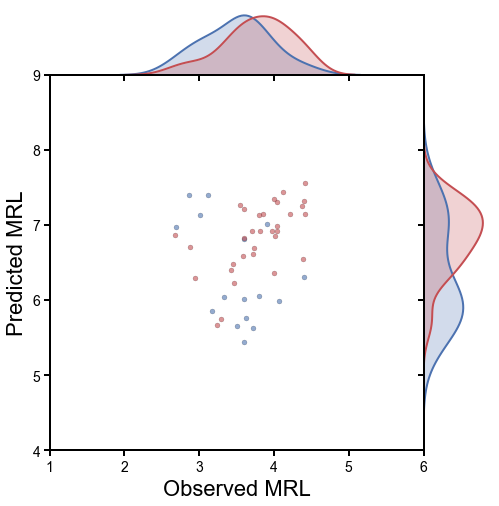

In [27]:
g = sns.JointGrid(x='rl', y="pred", data=atg_true, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=25, color=c1, linewidth=0.2, alpha='0.6', edgecolor='black')
f = g.fig
ax = f.gca()
# ax.set_yticks(np.arange(0,9.01, 1));
# ax.set_yticklabels(range(10),size=20);
# ax.set_xticks(np.arange(1,10.01, 1));
# ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(4,9)
ax.set_xlim(1,6)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':'b'})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = atg_false['rl'].values
g.y = atg_false['pred'].values
g.plot_joint(plt.scatter, s=25, linewidth=0.2, alpha='0.6', color='r', edgecolor='black')
g.plot_marginals(sns.kdeplot, shade='r', **{'linewidth':2, 'color':'r'})
f = g.fig

In [42]:
def baseContent(seq,verbose=False):
    """returns dictionary of ATGC content in the input sequence, assumes all uppercase already"""
    d = {'A':0.0,'T':0.0,'G':0.0,'C':0.0}
    length = len(seq)
    s = seq.encode('ascii','ignore')
    for b in 'ATGC':
        d[b] = s.count(b) / length
    if verbose:
        print(d)
    return d

In [44]:
off_diagonals[u'utr'].apply(lambda s: baseContent(s))

809      {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
999      {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1046     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1733     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1909     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3279     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3467     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3582     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3974     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4049     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4553     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4749     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
5424     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
6500     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
8461     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
8845     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9258     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9571     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9627     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10013    {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10366    {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10584    {u'A': 0, u'C': 0, u'T': 